In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [5]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.6 MB/s eta 0:00:00


In [7]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.6 MB/s eta 0:00:00


In [8]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
from vit_keras import vit

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model


import shap
shap.initjs()

IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 19
AUTO = tf.data.AUTOTUNE

In [9]:
# Creatin mirrored strategy and the model
stg = tf.distribute.MirroredStrategy()

### Reading Data

In [12]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path, images


train_images = create_images_list('/content/drive/MyDrive/data/Training')
valid_imaged = create_images_list('/content/drive/MyDrive/data/Validation/Validation')
test_images = create_images_list('/content/drive/MyDrive/data/Testing')

# look-up table
classes = {0:'not_smoking', 1 : 'smoking'}


train_data = pd.DataFrame({'img': train_images[0], 'label': np.NaN, 'image_name': train_images[1]})
valid_data = pd.DataFrame({'img': valid_imaged[0], 'label': np.NaN, 'image_name': valid_imaged[1]})
test_data = pd.DataFrame({'img': test_images[0], 'label': np.NaN, 'image_name': test_images[1]})


def create_class(X):
    reg = re.split("_", X)
    if reg[0] == 'notsmoking':
        return 0
    elif reg[0] == 'smoking':
        return 1
    else:
        print('wrong class ...')

train_data['label'] = train_data['image_name'].apply(create_class)
valid_data['label'] = valid_data['image_name'].apply(create_class)
test_data['label'] = test_data['image_name'].apply(create_class)


train_data = shuffle(train_data, random_state = SEED).reset_index(drop = True)
valid_data = shuffle(valid_data, random_state = SEED).reset_index(drop = True)
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)


print("train images -> ", train_data.shape[0])
print("valid images -> ", valid_data.shape[0])
print("test images -> ", test_data.shape[0])

train_data.head()



train images ->  716
valid images ->  180
test images ->  224


,img,label,image_name
0,/content/drive/MyDrive/data/Training/smoking_0...,1,smoking_0141.jpg
1,/content/drive/MyDrive/data/Training/smoking_0...,1,smoking_0227.jpg
2,/content/drive/MyDrive/data/Training/smoking_0...,1,smoking_0410.jpg
3,/content/drive/MyDrive/data/Training/notsmokin...,0,notsmoking_0407.jpg
4,/content/drive/MyDrive/data/Training/notsmokin...,0,notsmoking_0093.jpg


### Creating tf.data Pipeline

In [13]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 5, seed = SEED)

    return img, label

In [14]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


# Training dataset without shuffling and data augmantation operations for the classification stage
train_loader_feature = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset_feature = (train_loader_feature
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['img'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

### Feature Extraction

#### Pretrained ViT Model Feature Extractor

In [15]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 2)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(64, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(16, activation = 'gelu')(X)
    out = Dense(2, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()

    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc'] )

347502902/347502902 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 64)                49216     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                            

In [16]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 5, batch_size = BATCH_SIZE, validation_data = valid_dataset)
model.save("vit_feature_extractor.h5")

Epoch 1/5
23/23 [==============================] - 147s 3s/step - loss: 0.6026 - acc: 0.6774 - val_loss: 0.4044 - val_acc: 0.7778
Epoch 2/5
23/23 [==============================] - 32s 1s/step - loss: 0.3800 - acc: 0.8268 - val_loss: 0.2453 - val_acc: 0.8889
Epoch 3/5
23/23 [==============================] - 32s 1s/step - loss: 0.2466 - acc: 0.8799 - val_loss: 0.1121 - val_acc: 0.9611
Epoch 4/5
23/23 [==============================] - 33s 1s/step - loss: 0.1565 - acc: 0.9358 - val_loss: 0.0879 - val_acc: 0.9611
Epoch 5/5
23/23 [==============================] - 32s 1s/step - loss: 0.1028 - acc: 0.9581 - val_loss: 0.1098 - val_acc: 0.9611


In [17]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    val_eval_vit = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
6/6 [==============================] - 3s 424ms/step - loss: 0.1098 - acc: 0.9611
Validation Loss: 0.110
Validation Accuracy: 96.111 %
----------------------------------------------------------------------------------------------------
7/7 [==============================] - 38s 5s/step - loss: 0.1093 - acc: 0.9643
Test Loss: 0.109
Test Accuracy: 96.429 %


#### Classification

In [18]:
# Reading saved model and weights
feature_extr = tf.keras.models.load_model('/content/vit_feature_extractor.h5')

# Feature extraction model
feature_extractor_model = Model(inputs=feature_extr.input,
                                outputs=feature_extr.get_layer('the_feature_layer').output)


In [19]:
# Creating train features

with stg.scope():
    features = feature_extractor_model.predict(train_dataset_feature)

23/23 [==============================] - 15s 417ms/step


#### Dimensionality Reduction

In [20]:
# Applying PCA 21 components nearly equal to 0.99 variance ratio

pca_ = PCA(50)
pred_pca_ = pca_.fit(features)
pred_pca = pred_pca_.transform(features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))

train_features = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with a ViT feature extractor
train_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50
0,1.118636,0.965921,1.502581,2.107241,-0.799904,0.558551,0.313147,0.783679,0.459556,1.110245,...,-0.330695,-0.152083,-0.152136,0.194745,-0.592402,0.249318,-0.067558,-0.263045,0.025921,-0.111024
1,4.165333,0.008696,1.039215,1.587973,-0.416100,-0.186348,0.211133,-1.012207,-0.708014,0.401772,...,-0.424307,-0.954452,0.533242,0.107307,0.532838,-0.035577,-0.124312,-0.262541,-0.354005,-0.065892
2,6.048551,0.013262,-0.494900,-0.714133,0.998939,-1.054228,0.358411,-0.779269,-0.395193,0.014091,...,-0.301385,0.283560,-0.591841,-0.406945,-0.359525,0.050664,0.271335,0.033716,0.097627,-0.033241
3,-3.029342,-2.138400,-0.205220,1.014506,-1.120309,-0.287031,-0.452761,1.097097,-1.487764,-2.833923,...,-0.529732,0.212812,-0.413690,0.388855,-0.171974,-0.015399,-0.335249,0.172792,-0.006152,-0.170655
4,-7.064112,-2.329823,2.185883,-0.886328,0.480469,0.253618,1.547053,0.008176,-0.606914,0.571087,...,-0.326159,-0.645156,-0.289685,0.506714,0.296642,0.094458,-0.264353,-0.232761,0.033498,0.217294


#### Classification Tuned XGBClassifier Model

In [21]:
X_train = train_features
y_train =  train_data['label']


# XGBClassifier model (tuned with optuna)
xgb_model = XGBClassifier(learning_rate = 0.004407102852081284, max_depth = 7, subsample = 0.9589156602981981,
                          colsample_bytree = 0.6630333991896368, min_child_weight = 2)


# Training XGBClassifier model with features from the ViT feature extractor
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6630333991896368, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.004407102852081284,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
# Test set processing
# test feature exteaction -> applying PCA -> predictions of the XGBClassifier model

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_features = pca_.transform(test_features)
test_features = pd.DataFrame(test_features, columns = new_feature_column_names)


X_test = test_features
y_test = test_data['label']

test_pred = xgb_model.predict(X_test)

7/7 [==============================] - 3s 402ms/step


#### Test Results

In [23]:
# Predictions and scores

mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc = accuracy_score(y_test, test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

Mean Squared Error : 0.04911
Weighted F1 Score : 0.951
Accuracy Score : 95.089 %


#### Classification Report

In [24]:
clf_report = classification_report(y_test, test_pred, target_names = list(classes.values()))
print(clf_report)

              precision    recall  f1-score   support

 not_smoking       0.98      0.92      0.95       112
     smoking       0.92      0.98      0.95       112

    accuracy                           0.95       224
   macro avg       0.95      0.95      0.95       224
weighted avg       0.95      0.95      0.95       224



#### Confusion Matrix

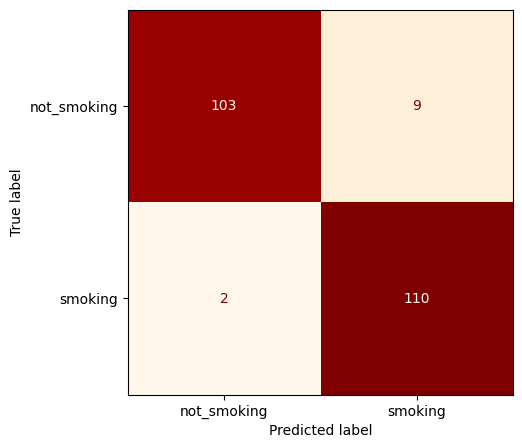

In [30]:
cm = confusion_matrix(y_test, test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax, cmap = 'OrRd', colorbar = False)

#### Feature Explanation w/SHAP

In [31]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

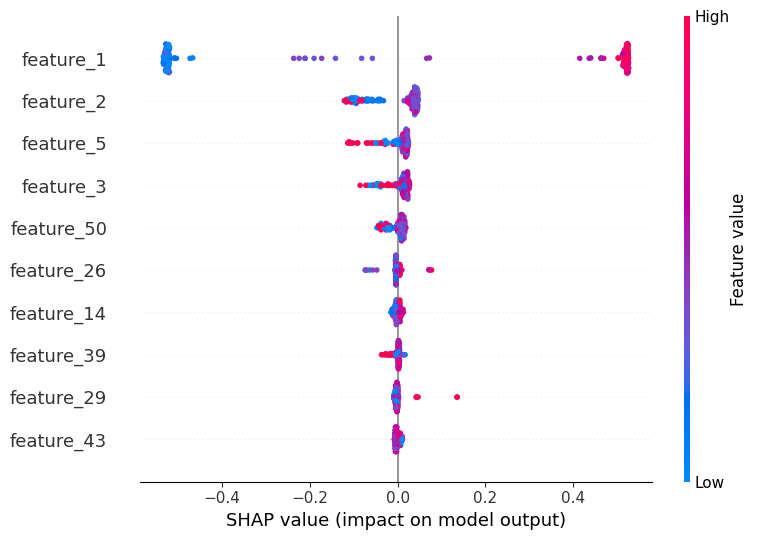

In [32]:
# all features explanation
shap.summary_plot(shap_values, X_test, max_display = 10)

#### Sample Prediction

In [33]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]

        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()


        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

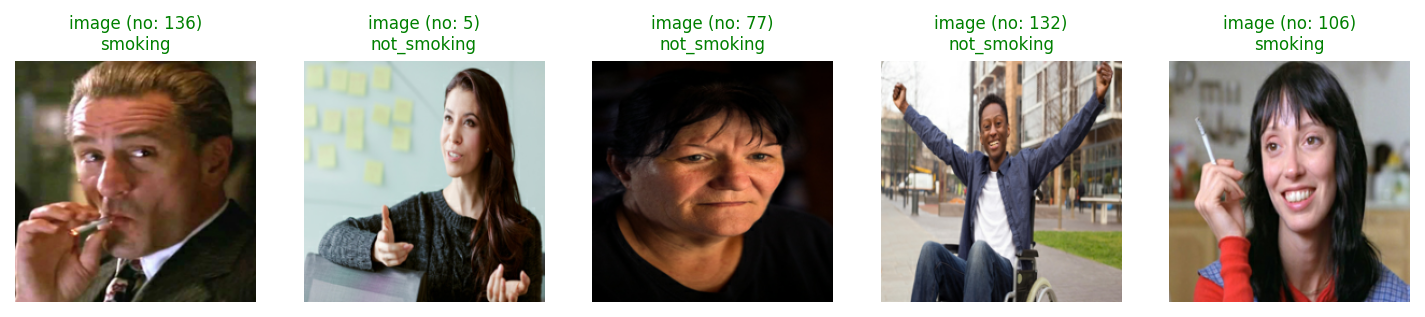

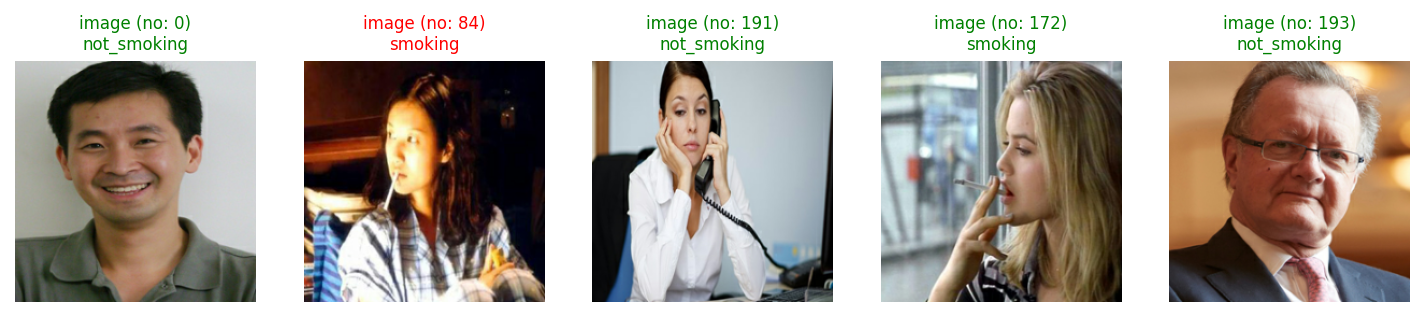

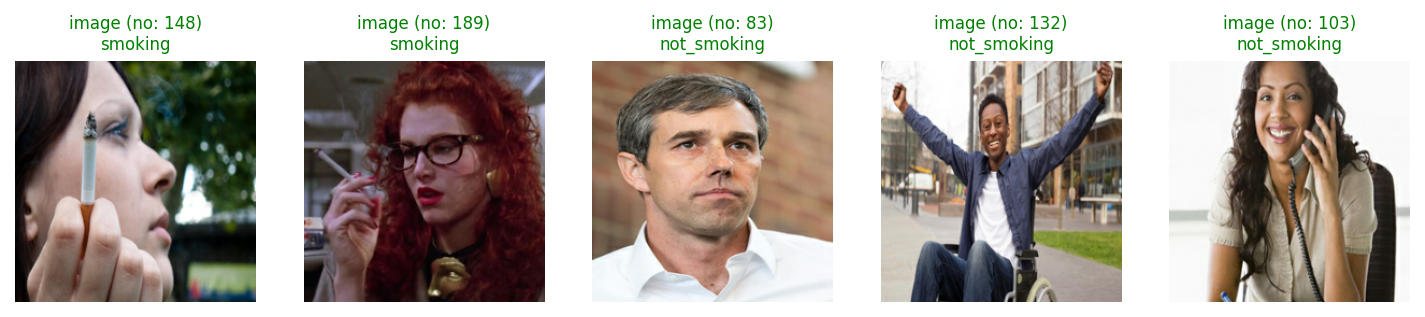

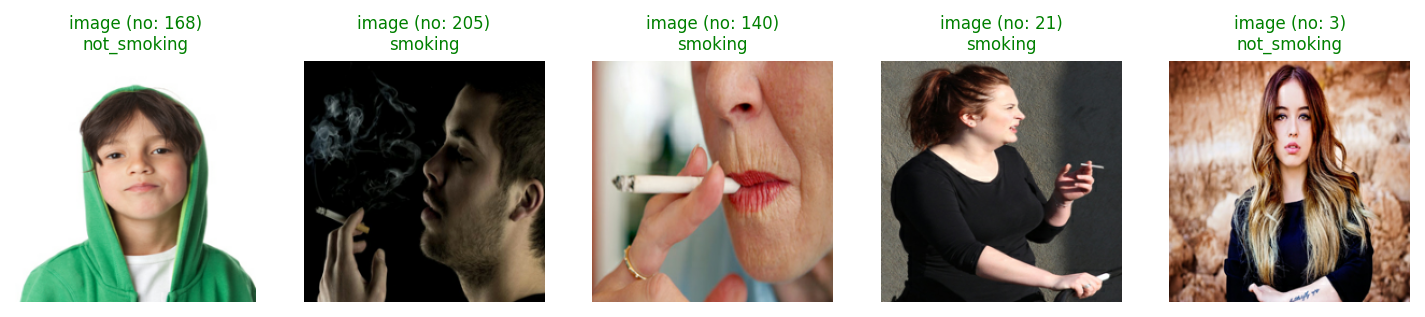

In [35]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 6)
random_test_sample_with_prediction(SEED = 985)
random_test_sample_with_prediction(SEED = 123)
random_test_sample_with_prediction(SEED = 76)